In [ ]:
!pip install torch==2.5.1

In [ ]:
!pip install pyg_lib torch_scatter torch_sparse torch_cluster torch_spline_conv -f https://data.pyg.org/whl/torch-2.5.1+cu124.html

In [ ]:
!pip install torch_geometric

In [ ]:
!pip install spacy
!python -m spacy download en_core_web_md

In [ ]:
import re
import torch
import spacy
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict
from torch.optim import SGD
from torch.nn import CrossEntropyLoss
from torch_geometric.nn import to_hetero
from torch_geometric.data import HeteroData, Data
from torch_geometric.loader import NeighborLoader, DataLoader
from torch.nn.functional import dropout, one_hot
from torch_geometric.nn import GCNConv, Linear, LightGCN
from torch.optim import Adam
from model_utils import train_classification
from lightgcn_recommendation import train
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.preprocessing import LabelEncoder

In [ ]:
product_dict = {}
user_set = set()
similar_edges = []
rating_edges = []

In [ ]:
valid_groups = {'Book', 'DVD', 'Music', 'Video'}

In [ ]:
import pandas as pd

In [ ]:
with open("amazon-meta.txt", encoding="latin1") as f:
  current = {}
  for line in f:
    line = line.strip()

    if line.startswith("Id:"):
      if "ASIN" in current and "title" in current and "group" in current and "salesrank" in current and "similar" in current:
        if current["group"] in valid_groups:
          product_dict[current["ASIN"]] = current
          for sim_asin in current["similar"]:
            similar_edges.append((current["ASIN"], sim_asin))
      current = {}

    elif line.startswith("ASIN:"):
      current["ASIN"] = line.split()[1]

    elif line.startswith("title:"):
      current["title"] = line[7:]

    elif line.startswith("group:"):
      current["group"] = line.split()[1]

    elif line.startswith("salesrank:"):
      current["salesrank"] = int(line.split()[1])

    elif line.startswith("similar:"):
      current["similar"] = line.split()[2:]

    elif line.startswith("reviews:"):
      current["reviews"] = []

    elif re.match(r"\d{4}-\d{1,2}-\d{1,2}", line):
      parts = line.split()
      user = parts[2]
      rating = int(parts[4])
      asin = current.get("ASIN")
      if asin and current["group"] in valid_groups:
        current["reviews"].append((user, rating))
        user_set.add(user)
          rating_edges.append((user, asin, rating))

  if "ASIN" in current and "title" in current and "group" in current and "salesrank" in current and "similar" in current:
    if current["group"] in valid_groups:
      product_dict[current["ASIN"]] = current
      for sim_asin in current["similar"]:
        similar_edges.append((current["ASIN"], sim_asin))

In [ ]:
label_encoder = LabelEncoder()

In [ ]:
product_groups = [product["group"] for product in product_dict.values()]

encoded_groups = label_encoder.fit_transform(product_groups)

for idx, asin in enumerate(product_dict):
    product_dict[asin]["class"] = encoded_groups[idx]

In [ ]:
dataset = HeteroData()

### Product Embedding



In [ ]:
df = pd.DataFrame.from_dict(product_dict, orient='index')
df.head(5)

,ASIN,title,group,salesrank,similar,reviews,class
1565657365,1565657365,Grosser Goodies: Beastly Bites That Look Bad b...,Book,1218764,[],[],0
0878333169,0878333169,The Steve Spurrier Story: From Heisman to Head...,Book,327199,"[1931249172, 158261847X, 1582613435, 158261113...","[(AB4OCHH0B4I9T, 5), (A246O0GE0LV5JO, 2)]",0
1570717877,1570717877,Supportive Cancer Care: The Complete Guide for...,Book,704179,[0809232618],[],0
0920852807,0920852807,Old-Fashioned Fruit Garden: The Best Way to Gr...,Book,1002253,[],[],0
0810910136,0810910136,California Fashion : From the Old West to New ...,Book,889639,[],"[(A2I6TS7GL3DLHC, 5)]",0


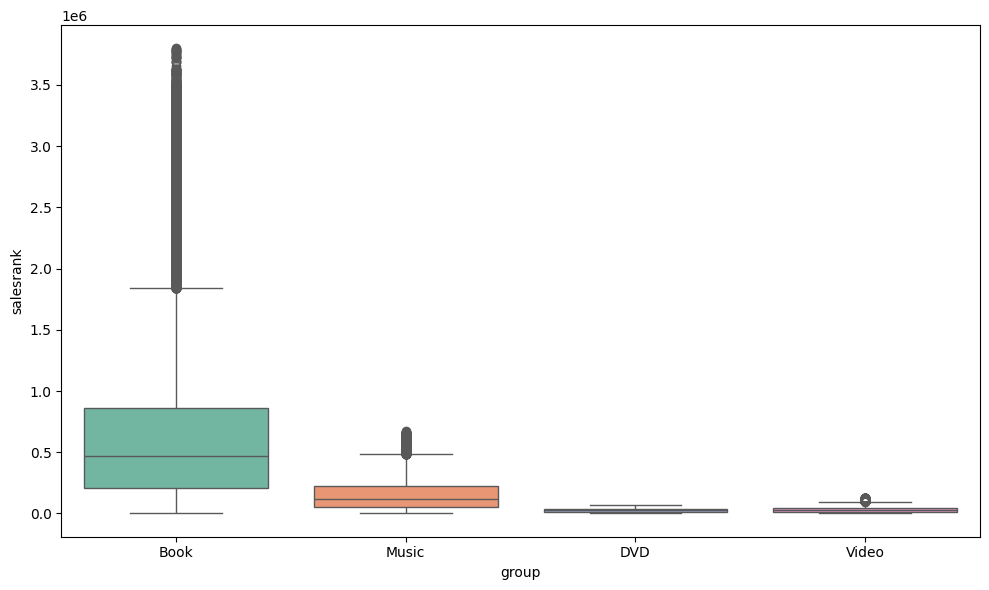

In [ ]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='group', y='salesrank', data=df, hue='group', palette='Set2')
plt.tight_layout()
plt.show()

Each of the valid classes has a different salesrank interval, which means that the class is highly correlated with the salesrank. This would cause data leakadge. Therefore, I'm only using the title embedding as the product's features.

In [ ]:
embedding_model = spacy.load("en_core_web_md")

In [ ]:
product_ids = list(product_dict.keys())
titles = [product["title"] for product in product_dict.values()]
title_embeddings = torch.stack([
    torch.tensor(embedding_model(title).vector) for title in titles
])

dataset['product'].x = title_embeddings

In [ ]:
dataset['product'].y = torch.tensor([product["class"] for product in product_dict.values()], dtype=torch.long)

### User Embedding

There is no user-specific data, so I'm using dummy values as features (1)

In [ ]:
user_ids = list(user_set)
dataset['user'].x = torch.ones(len(user_ids), 1)

In [ ]:
product_ids_set = set(product_ids)
valid_similar_edges = [(p1, p2) for p1, p2 in similar_edges if p1 in product_ids_set and p2 in product_ids_set]

### Edges

In [ ]:
product_id_to_index = {asin: idx for idx, asin in enumerate(product_ids)}

product_to_product_edges = [
    (product_id_to_index[p1], product_id_to_index[p2])
    for p1, p2 in valid_similar_edges
    if p1 in product_id_to_index and p2 in product_id_to_index
]

dataset['product', 'similar', 'product'].edge_index = torch.tensor(product_to_product_edges, dtype=torch.long).t().contiguous()

In [ ]:
user_id_to_index = {user: idx for idx, user in enumerate(user_ids)}

user_to_product_edges = []
ratings = []

for user, asin, rating in rating_edges:
    if user in user_id_to_index and asin in product_id_to_index:
        user_idx = user_id_to_index[user]
        product_idx = product_id_to_index[asin]

        user_to_product_edges.append((user_idx, product_idx))
        ratings.append(rating)

edge_index = torch.tensor(user_to_product_edges, dtype=torch.long).t().contiguous()
edge_attr = torch.tensor(ratings, dtype=torch.float)

dataset['user', 'rates', 'product'].edge_index = edge_index
dataset['user', 'rates', 'product'].edge_attr = edge_attr

In [ ]:
product_to_user_edges = [(product_idx, user_idx) for user_idx, product_idx in user_to_product_edges]

flipped_edge_index = torch.tensor(product_to_user_edges, dtype=torch.long).t().contiguous()
flipped_edge_attr = edge_attr

dataset['product', 'rated_by', 'user'].edge_index = flipped_edge_index
dataset['product', 'rated_by', 'user'].edge_attr = flipped_edge_attr

In [ ]:
dataset

In [ ]:
dataset_copy = dataset.clone()

# Recommendation System

In [ ]:
dataset = dataset_copy

In [ ]:
dataset2 = dataset.to_homogeneous()
dataset2

In [ ]:
dataset2 = dataset2.to('cuda')

In [ ]:
model_lightgcn = LightGCN(num_nodes=dataset.num_nodes,
                          embedding_dim=256,
                          num_layers=1)

In [ ]:
model_lightgcn = model_lightgcn.to('cuda')

In [ ]:
optimizer2 = Adam(model_lightgcn.parameters(), lr=0.0001)

In [ ]:
num_users = dataset['user'].num_nodes

In [ ]:
num_products = dataset['product'].num_nodes

In [ ]:
edges = dataset2.edge_index.t().cpu().numpy()
np.random.shuffle(edges)

In [ ]:
num_edges = edges.shape[0]
train_size = int(0.8 * num_edges)
test_size = num_edges - train_size

In [ ]:
train_edges = edges[:train_size]
test_edges = edges[train_size:]

In [ ]:
train_edges = torch.tensor(train_edges).t()
test_edges = torch.tensor(test_edges).t()

In [ ]:
train_data = Data(edge_index=train_edges, num_nodes=dataset2.num_nodes)
test_data = Data(edge_index=test_edges, num_nodes=dataset2.num_nodes)
test_users = test_edges[0].unique()

In [ ]:
train_data = train_data.to('cuda')

In [ ]:
test_data = test_data.to('cuda')

In [ ]:
train_loader = DataLoader(range(train_edges.size(1)), shuffle=True, batch_size=16)

In [ ]:
test_loader = DataLoader(range(test_edges.size(1)), shuffle=False, batch_size=16)

In [ ]:
def train(dataset, train_loader, model, optimizer, num_users, num_products, epochs=1):
  model = model.to('cuda')
  dataset = dataset.to('cuda')

  for epoch in range(epochs):
    total_loss, total_examples = 0, 0

    for node_ids in train_loader:
      node_ids = node_ids.to('cuda')
      pos_edge_label_index = dataset.edge_index[:, node_ids]
      neg_edge_label_index = torch.stack([pos_edge_label_index[0],
                                          torch.randint(num_products, num_products + num_users,
                                                        (node_ids.numel(),), device='cuda')],
                                          dim=0)
      edge_label_index = torch.cat([pos_edge_label_index, neg_edge_label_index], dim=1)

      optimizer.zero_grad()

      pos_rank, neg_rank = model(dataset.edge_index, edge_label_index).chunk(2)

      loss = model.recommendation_loss(pos_rank, neg_rank, node_id=edge_label_index.unique())
      loss.backward()
      optimizer.step()

      total_loss += float(loss) * pos_rank.numel()
      total_examples += pos_rank.numel()

      print(f'Epoch: {epoch:03d}, Loss: {total_loss / total_examples:.4f}')

In [ ]:
train(dataset=dataset2,
      train_loader=train_loader,
      model=model_lightgcn,
      optimizer=optimizer2,
      num_users=num_users,
      num_products=num_products,
      epochs=160)

In [ ]:
@torch.no_grad()
def evaluate(model, dataset2, test_loader, num_users, num_products, k=1):
    dst_index = torch.arange(num_users, num_users + num_products).to('cuda')

    top_k = model.recommend(dataset2.edge_index,
                            src_index=torch.arange(num_users),
                            dst_index=dst_index,
                            k=k)

    hits = 0
    total = 0

    for batch in test_loader:
      users, items = dataset2.edge_index[:, batch]

      for user, item in zip(users, items):
        user = int(user.item())
        item = int(item.item())

        if user in top_k[item]:
          hits += 1
        total += 1

    recall_at_k = hits / total
    precision_at_k = hits / k
    f1_at_k = 2 * (precision_at_k * recall_at_k) / (precision_at_k + recall_at_k)

    print(f"Recall@{k}: {recall_at_k:.4f}")
    print(f"Precision@{k}: {precision_at_k:.4f}")
    print(f"F1@{k}: {f1_at_k:.4f}")

    return recall_at_k, precision_at_k, f1_at_k

In [ ]:
evaluate(model=model_lightgcn,
         dataset2=dataset2,
         test_loader=test_loader,
         num_users=num_users,
         num_products=num_products,
         k=1)

In [ ]:
evaluate(model=model_lightgcn,
         dataset2=dataset2,
         test_loader=test_loader,
         num_users=num_users,
         num_products=num_products,
         k=5)

In [ ]:
evaluate(model=model_lightgcn,
         dataset2=dataset2,
         test_loader=test_loader,
         num_users=num_users,
         num_products=num_products,
         k=10)